In [1]:
import configparser
from tqdm import tqdm
import pandas as pd
import os
import math
import openslide
import numpy as np
from openslide.deepzoom import *
import cv2
import PIL
import time
import haar

import math
from random import gauss


In [2]:
# Function to read and parse config file
def read_config(file_path):
    t_config = {}
    config = configparser.ConfigParser()
    config.read(file_path)
    for section in config.sections():
        for key in config[section]:
            t_config[key] = config[section][key]
            
    # Change boolean type
    if t_config['replace']=='False':
        t_config['replace']=False
    else:
        t_config['replace']=True
    
    if t_config['use_residuals']=='False':
        t_config['use_residuals']=False
    else:
        t_config['use_residuals']=True

    return t_config
 


In [3]:
# Read config file
config = read_config("./config.ini")
config

{'patch_purity_file': 'patch_purity_temp.csv',
 'patches_dir': 'patches',
 'tiles_per_slide': '1200',
 'replace': False,
 'use_residuals': True,
 'tiles_thres': '140',
 '10': '100',
 '20': '90',
 '30': '80',
 '40': '70',
 '50': '60',
 '60': '50',
 '70': '40',
 '80': '30',
 '90': '20',
 '100': '10',
 'avg_purity': '0.3',
 'var_purity': '0.4'}

In [4]:
###
# read patch purity file
patch_purities = pd.read_csv(config['patch_purity_file'])  
patch_purities = patch_purities.loc[:,["Fold","ImageNumber","Purity","CancerType"]]
patch_purities
# # sort by purity
# patch_purities = patch_purities.sort_values(by=['Purity'])

,Fold,ImageNumber,Purity,CancerType
0,1,0,0.428571,Breast
1,1,1,0.714286,Breast
2,1,2,0.700000,Breast
3,1,3,1.000000,Breast
4,1,4,0.428571,Breast
...,...,...,...,...
7896,3,2717,0.048780,Colon
7897,3,2718,0.333333,Colon
7898,3,2719,0.000000,Colon
7899,3,2720,0.000000,Colon


In [6]:
# Function to read patch purity file
patch_purities_brecahad = pd.read_csv('brecahad_purity_counts.csv')  
patch_purities_brecahad = patch_purities_brecahad.loc[:,["Name","Purity"]]
patch_purities_brecahad


,Name,Purity
0,Case_1-01_0_0,0.9091
1,Case_1-01_0_1,1.0000
2,Case_1-01_0_2,1.0000
3,Case_1-01_0_3,1.0000
4,Case_1-01_1_0,1.0000
...,...,...
3883,Case_9-10_4_3,0.8000
3884,Case_9-10_5_0,1.0000
3885,Case_9-10_5_1,0.8750
3886,Case_9-10_5_2,1.0000


In [6]:
# Function to read patch purity file
patch_purities_nucls = pd.read_csv('NuCLS_counts.csv')  
patch_purities_nucls = patch_purities_nucls.loc[:,["Name","Purity"]]
patch_purities_nucls


,Name,Purity
0,TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_l...,1.000000
1,TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_l...,0.000000
2,TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_l...,0.875000
3,TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_l...,1.000000
4,TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_l...,0.875000
...,...,...
1739,TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_l...,0.000000
1740,TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_l...,0.971429
1741,TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_l...,0.000000
1742,TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_l...,0.903226


In [7]:
patch_purities

,Fold,ImageNumber,Purity,CancerType
0,1,0,0.428571,Breast
1,1,1,0.714286,Breast
2,1,2,0.700000,Breast
3,1,3,1.000000,Breast
4,1,4,0.428571,Breast
...,...,...,...,...
7896,3,2717,0.048780,Colon
7897,3,2718,0.333333,Colon
7898,3,2719,0.000000,Colon
7899,3,2720,0.000000,Colon


array([[<AxesSubplot:title={'center':'Purity'}>]], dtype=object)

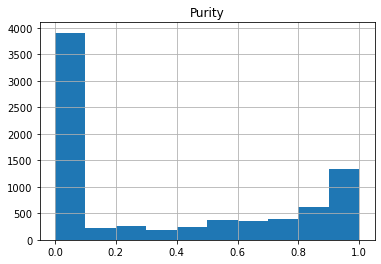

In [9]:
#pannuke
patch_purities.hist(column="Purity")

array([[<AxesSubplot:title={'center':'Purity'}>]], dtype=object)

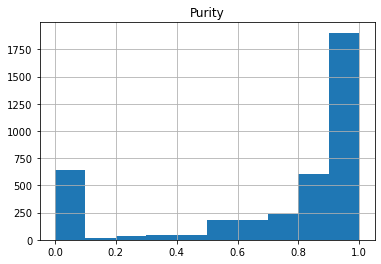

In [14]:
#brecahad
patch_purities_brecahad.hist(column="Purity")

array([[<AxesSubplot:title={'center':'Purity'}>]], dtype=object)

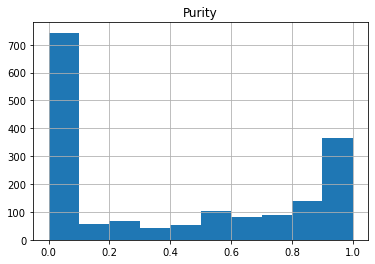

In [15]:
#nucls
patch_purities_nucls.hist(column="Purity")

CancerType
Adrenal_gland    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Bile-duct        [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Bladder          [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Breast           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Cervix           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Colon            [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Esophagus        [[AxesSubplot(0.125,0.125;0.775x0.755)]]
HeadNeck         [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Kidney           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Liver            [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Lung             [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Ovarian          [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Pancreatic       [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Prostate         [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Skin             [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Stomach          [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Testis           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Thy

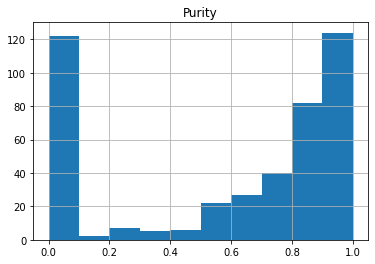

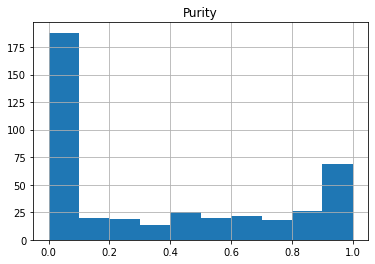

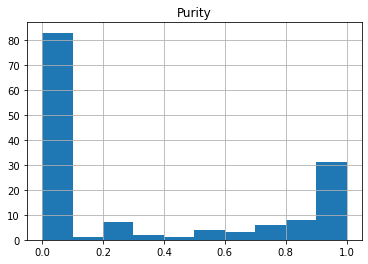

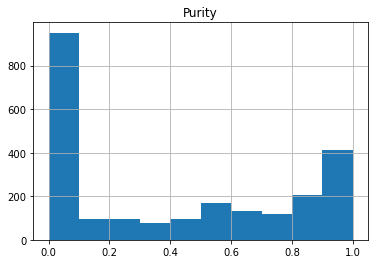

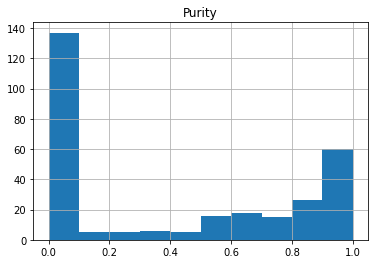

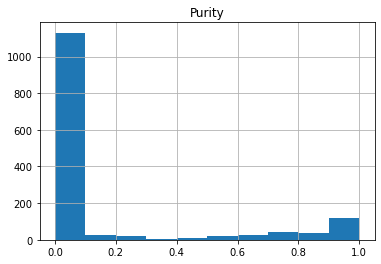

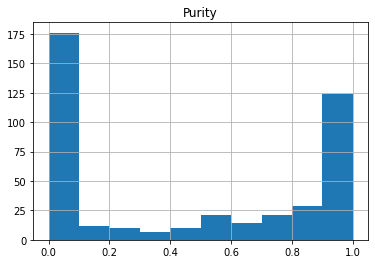

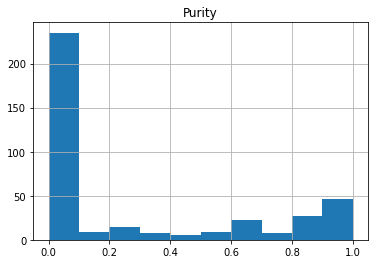

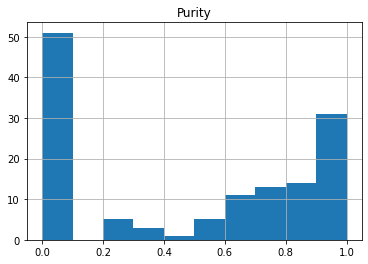

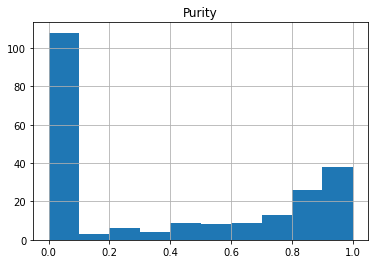

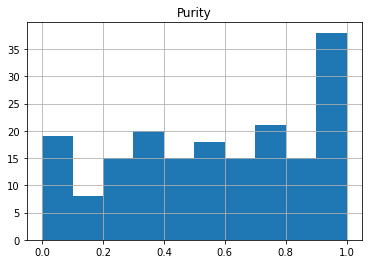

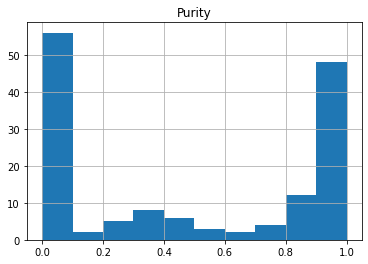

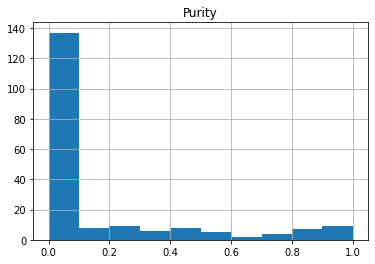

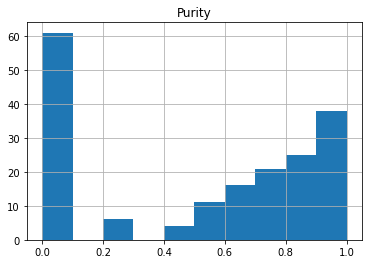

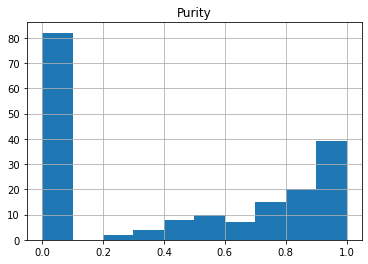

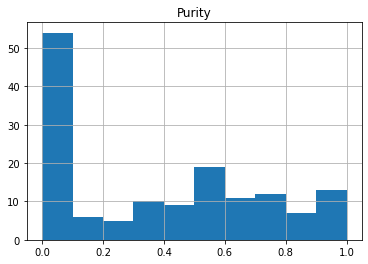

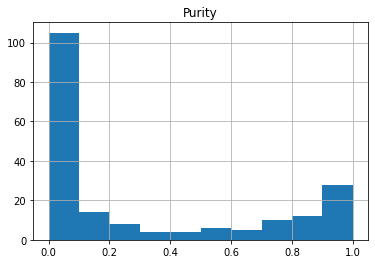

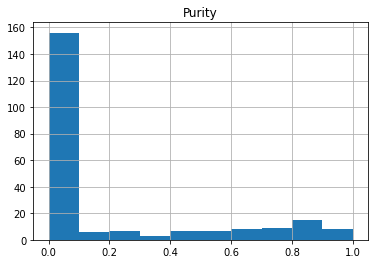

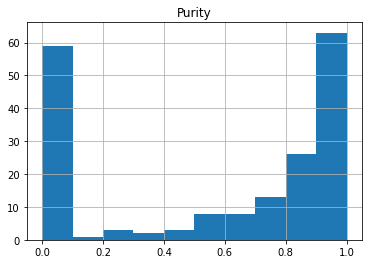

In [10]:
patch_purities.groupby('CancerType').hist(column="Purity")

In [7]:
patch_purities['CancerType'].value_counts()

Breast           2351
Colon            1440
Adrenal_gland     437
Esophagus         424
Bile-duct         420
HeadNeck          384
Cervix            293
Thyroid           226
Liver             224
Testis            196
Pancreatic        195
Skin              187
Uterus            186
Lung              184
Prostate          182
Bladder           146
Stomach           146
Ovarian           146
Kidney            134
Name: CancerType, dtype: int64

In [13]:
####
cancer_types = patch_purities['CancerType'].unique()
cancer_types

array(['Breast', 'Colon', 'Lung', 'Kidney', 'Prostate', 'Bladder',
       'Stomach', 'Ovarian', 'Esophagus', 'Pancreatic', 'Uterus',
       'Thyroid', 'Skin', 'Cervix', 'Adrenal_gland', 'Bile-duct',
       'Testis', 'HeadNeck', 'Liver'], dtype=object)

# tests with bin distribution


In [5]:
######
# Function to bin purities by decile
def bin_purity(row):
    if 0.0 <= row['Purity'] <= 0.1:
        return 10
    elif 0.1 < row['Purity'] <= 0.2:
        return 20
    elif 0.2 < row['Purity'] <= 0.3:
        return 30
    elif 0.3 < row['Purity'] <= 0.4:
        return 40
    elif 0.4 < row['Purity'] <= 0.5:
        return 50
    elif 0.5 < row['Purity'] <= 0.6:
        return 60
    elif 0.6 < row['Purity'] <= 0.7:
        return 70
    elif 0.7 < row['Purity'] <= 0.8:
        return 80
    elif 0.8 < row['Purity'] <= 0.9:
        return 90
    return 100


In [6]:
########
patch_purities['Bin']=patch_purities.apply(lambda row:bin_purity(row),axis=1)

In [10]:
patch_purities_brecahad['Bin']=patch_purities_brecahad.apply(lambda row:bin_purity(row),axis=1)
patch_purities_nucls['Bin']=patch_purities_nucls.apply(lambda row:bin_purity(row),axis=1)

In [11]:
patch_purities_brecahad

,Name,Purity,Bin
0,Case_1-01_0_0,0.9091,100
1,Case_1-01_0_1,1.0000,100
2,Case_1-01_0_2,1.0000,100
3,Case_1-01_0_3,1.0000,100
4,Case_1-01_1_0,1.0000,100
...,...,...,...
3883,Case_9-10_4_3,0.8000,80
3884,Case_9-10_5_0,1.0000,100
3885,Case_9-10_5_1,0.8750,90
3886,Case_9-10_5_2,1.0000,100


In [ ]:
# images in each bin

In [39]:
pannuke = patch_purities[patch_purities['CancerType']=='Breast']['Bin'].value_counts()

In [40]:
brecahad = patch_purities_brecahad['Bin'].value_counts()

In [41]:
nucls = patch_purities_nucls['Bin'].value_counts()

In [42]:
total = pannuke + brecahad + nucls

In [43]:
total

10     2343
20      196
30      165
40      207
50      326
60      272
70      394
80      619
90      867
100    2594
Name: Bin, dtype: int64

In [17]:
###
patch_purities['Weight'] = patch_purities['Bin'].map({
    10: config['10'],
    20: config['20'],
    30: config['30'],
    40: config['40'],
    50: config['50'],
    60: config['60'],
    70: config['70'],
    80: config['80'],
    90: config['90'],
    100: config['100']
})


In [18]:
#########
patch_purities['Weight']=patch_purities['Weight'].astype(str).astype(int)

In [19]:
patch_purities.dtypes

Fold             int64
ImageNumber      int64
Purity         float64
CancerType      object
Bin              int64
Weight           int32
dtype: object

In [20]:
patch_purities

,Fold,ImageNumber,Purity,CancerType,Bin,Weight
0,1,0,0.428571,Breast,50,60
1,1,1,0.714286,Breast,80,30
2,1,2,0.700000,Breast,70,40
3,1,3,1.000000,Breast,100,10
4,1,4,0.428571,Breast,50,60
...,...,...,...,...,...,...
7896,3,2717,0.048780,Colon,10,100
7897,3,2718,0.333333,Colon,40,70
7898,3,2719,0.000000,Colon,10,100
7899,3,2720,0.000000,Colon,10,100


## WS PURITY FORMAT

### CSV file formats:

#### DBSCAN clusters (TileClusterSubset_120)
Column names:
    ,	Slide,	Tile,	Cluster,	Subset


#### TissueType.csv
index, slide_name, cancer_type
Column names: 
    , 0, 1

#### Data split csv (TP_Purity_list.csv)
index,slide_name, caseID (slide_name), tumor purity, dataset (train/test/validation)
Column names:
    , Slide_SVS_Name, CaseID,	TP_VALUE,	Dataset

### Patch image directory format:
Cancer_type_folder/SLIDE_NAME_FOLDER/TILE_NAME.JPG





## case questions:

tiles_per_slide = 1200
tiles_in_cohort = 2450
50 slides? 130 slides?

subset size is 120, so slides < 120 patches will be ignored

SYN-(COHORT)-SLIDE#

# list of weights

check:
length is the same for all bins


In [26]:
# # Function to group residual/remaining tiles as a slide without considering distribution
# # Params:
# # patch_purities -> main table with all tiles
# # cohort -> cancer cohort in consideration
# # config?
# # Updates the main table to remove grouped tiles and returns grouped slide
# def group_remaining(patch_purities, cohort, slides):
#     if config['use_residuals']:
#         slide_sample = patch_purities[patch_purities['CancerType']==cohort]
#         patch_purities=patch_purities.drop(slide_sample.index)
#         total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
#         assert(total_patches==0)
#         slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
#     else:
        
        

In [19]:
# Function to assemble slide
# Params: 
# patch_purities -> main table with patch level purities
# cancer_types -> list of cancer cohorts
# Returns: Dictionary of cancer_type -> dict of slides -> tiles
def assemble_slides(patch_purities, cancer_types):
    slides={}
    # slide counter per cohort 
    i=1
    for cohort in cancer_types:
        # number of patches per cohort
        total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
        # tiles per slide threshold check:
        if (total_patches >= int(config['tiles_per_slide'])):
            print(cohort,":", len(patch_purities[patch_purities['CancerType']==cohort]), "patches")
            slides[cohort]={}
            while total_patches>=int(config['tiles_per_slide']):
                # sample and remove
                print(len(patch_purities['CancerType']==cohort))
                slide_sample = patch_purities[patch_purities['CancerType']==cohort].sample(
                    n=int(config['tiles_per_slide']),
                    replace=config['replace'],
                    weights='Weight',
                    random_state=37
                )
                patch_purities=patch_purities.drop(slide_sample.index)
                total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
                slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
                print('SYN-'+cohort+'-'+str(i),"slide assembled with", len(slide_sample), "patches")
                i+=1

            # check tiles threshold to discard or add remaining slides based on flag
            if config['use_residuals'] and total_patches >= int(config['tiles_thres']):
                slide_sample = patch_purities[patch_purities['CancerType']==cohort]
                patch_purities=patch_purities.drop(slide_sample.index)
                total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
                assert(total_patches==0)
                slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
                print('SYN-'+cohort+'-'+str(i),"slide assembled with", len(slide_sample), "residual patches")
                # reset index
                i=1
            else:
                print(cohort,": discarded", total_patches, "patches. (Thres):",config['tiles_thres'])
                patch_purities=patch_purities.drop(patch_purities[patch_purities['CancerType']==cohort].index)
                total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
                assert(total_patches==0)
                # reset index
                i=1


        else:
            print(cohort,":", len(patch_purities[patch_purities['CancerType']==cohort]), "patches")
            # check residual flag and threshold to add or discard remaining slides
            if config['use_residuals'] and total_patches >= int(config['tiles_thres']):
                slides[cohort]={}
                slide_sample = patch_purities[patch_purities['CancerType']==cohort]
                patch_purities=patch_purities.drop(slide_sample.index)
                total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
                assert(total_patches==0)
                slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
                print('SYN-'+cohort+'-'+str(i),"slide assembled with", len(slide_sample), "residual patches")

            else:
                print(cohort,": discarded", total_patches, "patches. (Thres):",config['tiles_thres'])
                patch_purities=patch_purities.drop(patch_purities[patch_purities['CancerType']==cohort].index)
                total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
                assert(total_patches==0)
                
    return slides
    

In [22]:
slides = assemble_slides(patch_purities, cancer_types)

Breast : 2351 patches
SYN-Breast-1 slide assembled with 1200 patches
SYN-Breast-2 slide assembled with 1151 residual patches
Colon : 1440 patches
SYN-Colon-1 slide assembled with 1200 patches
SYN-Colon-2 slide assembled with 240 residual patches
Lung : 184 patches
SYN-Lung-1 slide assembled with 184 residual patches
Kidney : 134 patches
Kidney : discarded 134 patches. (Thres): 140
Prostate : 182 patches
SYN-Prostate-1 slide assembled with 182 residual patches
Bladder : 146 patches
SYN-Bladder-1 slide assembled with 146 residual patches
Stomach : 146 patches
SYN-Stomach-1 slide assembled with 146 residual patches
Ovarian : 146 patches
SYN-Ovarian-1 slide assembled with 146 residual patches
Esophagus : 424 patches
SYN-Esophagus-1 slide assembled with 424 residual patches
Pancreatic : 195 patches
SYN-Pancreatic-1 slide assembled with 195 residual patches
Uterus : 186 patches
SYN-Uterus-1 slide assembled with 186 residual patches
Thyroid : 226 patches
SYN-Thyroid-1 slide assembled with 226

In [48]:
slides

{'Breast': {'SYN-Breast-1':       Fold  ImageNumber    Purity CancerType  Bin  Weight
  5789     3          610  0.000000     Breast   10     100
  2886     2          230  0.000000     Breast   10     100
  411      1          411  0.428571     Breast   50      60
  3188     2          532  0.000000     Breast   10     100
  3281     2          625  0.000000     Breast   10     100
  ...    ...          ...       ...        ...  ...     ...
  1728     1         1728  0.844156     Breast   90      20
  5402     3          223  0.000000     Breast   10     100
  5343     3          164  0.000000     Breast   10     100
  3324     2          668  0.538462     Breast   60      50
  5354     3          175  0.000000     Breast   10     100
  
  [1200 rows x 6 columns],
  'SYN-Breast-2':       Fold  ImageNumber    Purity CancerType  Bin  Weight
  1        1            1  0.714286     Breast   80      30
  4        1            4  0.428571     Breast   50      60
  5        1            5  0

In [18]:
slides={}

# slide counter
i=1
for cohort in cancer_types:
    
    # number of patches per cohort
    total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
    if (total_patches >= int(config['tiles_per_slide'])):
        slides[cohort]={}
        while total_patches>=int(config['tiles_per_slide']):
            # sample and remove
            slide_sample = patch_purities[patch_purities['CancerType']==cohort].sample(
            n=int(config['tiles_per_slide']),
            replace=config['replace'],
            weights='Weight',
            random_state=37
            )
            patch_purities=patch_purities.drop(slide_sample.index)
            total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
            slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
            i+=1
        
        # check tiles threshold to discard or add remaining slides
        if total_patches >= config['tiles_thres']:
            slide_sample = patch_purities[patch_purities['CancerType']==cohort]
            patch_purities=patch_purities.drop(slide_sample.index)
            total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
            assert(total_patches==0)
            slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
            # reset index
            i=1
        else:
            patch_purities=patch_purities.drop(patch_purities[patch_purities['CancerType']==cohort].index)
            total_patches = len(patch_purities[patch_purities['CancerType']==cohort])
            assert(total_patches==0)
            slides[cohort]['SYN-'+cohort+'-'+str(i)]=slide_sample
            # reset index
            i=1
            
            
    else:
        print(cohort,"has only", len(patch_purities[patch_purities['CancerType']==cohort]), "patches")

7901


TypeError: '>=' not supported between instances of 'int' and 'str'

In [24]:
for key, value in slides.items():
    print (key)
    for key2, value2 in value.items():
        print (key2)

Colon
SYN-Colon-1
Breast
SYN-Breast-2


In [31]:
slides

{'Colon': {'SYN-Colon-1':       Fold  ImageNumber    Purity CancerType  Bin  Weight
  6549     3         1370  0.288889      Colon   30      80
  7108     3         1929  0.000000      Colon   10     100
  5984     3          805  0.000000      Colon   10     100
  7058     3         1879  0.000000      Colon   10     100
  7068     3         1889  0.000000      Colon   10     100
  ...    ...          ...       ...        ...  ...     ...
  785      1          785  0.916667      Colon  100      10
  1987     1         1987  0.000000      Colon   10     100
  2024     1         2024  0.000000      Colon   10     100
  791      1          791  0.947368      Colon  100      10
  1826     1         1826  0.000000      Colon   10     100
  
  [1200 rows x 6 columns]},
 'Breast': {'SYN-Breast-2':       Fold  ImageNumber    Purity CancerType  Bin  Weight
  5365     3          186  0.800000     Breast   80      30
  205      1          205  0.000000     Breast   10     100
  2834     2       

In [26]:
patch_purities

,Fold,ImageNumber,Purity,CancerType,Bin,Weight
2732,2,76,0.0,Breast,10,100
2737,2,81,0.0,Breast,10,100
2738,2,82,0.0,Breast,10,100
5355,3,176,0.0,Breast,10,100
5351,3,172,0.0,Breast,10,100
...,...,...,...,...,...,...
1699,1,1699,1.0,Breast,100,10
1701,1,1701,1.0,Breast,100,10
1702,1,1702,1.0,Breast,100,10
6522,3,1343,1.0,Bile-duct,100,10


# list of purity


In [71]:
# Function to read and parse config file
def read_config(file_path):
    bins=['10','20','30','40','50','60','70','80','90','100']
    t_config = {}
    config = configparser.ConfigParser()
    config.read(file_path)
    for section in config.sections():
        for key in config[section]:
            t_config[key] = config[section][key]
            
    # Change boolean type
    if t_config['replace']=='False':
        t_config['replace']=False
    else:
        t_config['replace']=True
    
    if t_config['use_residuals']=='False':
        t_config['use_residuals']=False
    else:
        t_config['use_residuals']=True
        
    # Make purities into list and check list 
    p_bins = []
    for t_bin in bins:
        t_config[t_bin] = t_config[t_bin].split(",")
        
        # Check if zero weights are given
        if '0' in t_config[t_bin]:
            raise ValueError('Weight cannot be zero!')
        
        p_bins.append(t_config[t_bin])
    
    # Check list size
    it = iter(p_bins)
    the_len = len(next(it))
    if not all(len(l) == the_len for l in it):
        raise ValueError('Bin list must have same length!')
                
    return t_config
 


In [72]:
# Read config file
config = read_config("./config_list.ini")
config

{'patch_purity_file': 'patch_purity_temp.csv',
 'patches_dir': 'patches',
 'tiles_per_slide': '1200',
 'replace': False,
 'use_residuals': True,
 'tiles_thres': '140',
 '10': ['100', '80', '60', '40', '20', '10'],
 '20': ['90', '70', '50', '30', '20', '10'],
 '30': ['80', '60', '40', '20', '10', '10'],
 '40': ['70', '50', '40', '30', '20', '10'],
 '50': ['60', '50', '40', '30', '20', '10'],
 '60': ['50', '40', '30', '20', '10', '10'],
 '70': ['40', '30', '30', '20', '20', '10'],
 '80': ['30', '30', '20', '20', '20', '10'],
 '90': ['20', '20', '20', '10', '10', '10'],
 '100': ['10', '10', '10', '10', '10', '10'],
 'avg_purity': '0.3',
 'var_purity': '0.4'}

In [73]:
###
# Loop through all purities in list and generate slides
slides_list = {}
for i in range (0,len(config['10'])):
    # assign weights
    patch_purities['Weight'] = patch_purities['Bin'].map({
    10: config['10'][i],
    20: config['20'][i],
    30: config['30'][i],
    40: config['40'][i],
    50: config['50'][i],
    60: config['60'][i],
    70: config['70'][i],
    80: config['80'][i],
    90: config['90'][i],
    100: config['100'][i]
    })
    
    patch_purities['Weight']=patch_purities['Weight'].astype(str).astype(int)

    slides = assemble_slides(patch_purities, cancer_types)
    slides_list['config-'+str(i)] = slides


Breast : 1151 patches
SYN-Breast-1 slide assembled with 1151 residual patches
Colon : 1440 patches
5550
SYN-Colon-1 slide assembled with 1200 patches
SYN-Colon-2 slide assembled with 240 residual patches
Lung : 184 patches
SYN-Lung-1 slide assembled with 184 residual patches
Kidney : 134 patches
Kidney : discarded 134 patches. (Thres): 140
Prostate : 182 patches
SYN-Prostate-1 slide assembled with 182 residual patches
Bladder : 146 patches
SYN-Bladder-1 slide assembled with 146 residual patches
Stomach : 146 patches
SYN-Stomach-1 slide assembled with 146 residual patches
Ovarian : 146 patches
SYN-Ovarian-1 slide assembled with 146 residual patches
Esophagus : 424 patches
SYN-Esophagus-1 slide assembled with 424 residual patches
Pancreatic : 195 patches
SYN-Pancreatic-1 slide assembled with 195 residual patches
Uterus : 186 patches
SYN-Uterus-1 slide assembled with 186 residual patches
Thyroid : 226 patches
SYN-Thyroid-1 slide assembled with 226 residual patches
Skin : 187 patches
SYN-S

SYN-Uterus-1 slide assembled with 186 residual patches
Thyroid : 226 patches
SYN-Thyroid-1 slide assembled with 226 residual patches
Skin : 187 patches
SYN-Skin-1 slide assembled with 187 residual patches
Cervix : 293 patches
SYN-Cervix-1 slide assembled with 293 residual patches
Adrenal_gland : 437 patches
SYN-Adrenal_gland-1 slide assembled with 437 residual patches
Bile-duct : 420 patches
SYN-Bile-duct-1 slide assembled with 420 residual patches
Testis : 196 patches
SYN-Testis-1 slide assembled with 196 residual patches
HeadNeck : 384 patches
SYN-HeadNeck-1 slide assembled with 384 residual patches
Liver : 224 patches
SYN-Liver-1 slide assembled with 224 residual patches


In [76]:
for key, value in slides_list.items() :
    print(key)
    for key1, value1 in value.items():
        print ('\t',key1)
        for key2, value2 in value1.items():
            print ('\t\t',key2)

config-0
	 Breast
		 SYN-Breast-1
	 Colon
		 SYN-Colon-1
		 SYN-Colon-2
	 Lung
		 SYN-Lung-1
	 Prostate
		 SYN-Prostate-1
	 Bladder
		 SYN-Bladder-1
	 Stomach
		 SYN-Stomach-1
	 Ovarian
		 SYN-Ovarian-1
	 Esophagus
		 SYN-Esophagus-1
	 Pancreatic
		 SYN-Pancreatic-1
	 Uterus
		 SYN-Uterus-1
	 Thyroid
		 SYN-Thyroid-1
	 Skin
		 SYN-Skin-1
	 Cervix
		 SYN-Cervix-1
	 Adrenal_gland
		 SYN-Adrenal_gland-1
	 Bile-duct
		 SYN-Bile-duct-1
	 Testis
		 SYN-Testis-1
	 HeadNeck
		 SYN-HeadNeck-1
	 Liver
		 SYN-Liver-1
config-1
	 Breast
		 SYN-Breast-1
	 Colon
		 SYN-Colon-1
		 SYN-Colon-2
	 Lung
		 SYN-Lung-1
	 Prostate
		 SYN-Prostate-1
	 Bladder
		 SYN-Bladder-1
	 Stomach
		 SYN-Stomach-1
	 Ovarian
		 SYN-Ovarian-1
	 Esophagus
		 SYN-Esophagus-1
	 Pancreatic
		 SYN-Pancreatic-1
	 Uterus
		 SYN-Uterus-1
	 Thyroid
		 SYN-Thyroid-1
	 Skin
		 SYN-Skin-1
	 Cervix
		 SYN-Cervix-1
	 Adrenal_gland
		 SYN-Adrenal_gland-1
	 Bile-duct
		 SYN-Bile-duct-1
	 Testis
		 SYN-Testis-1
	 HeadNeck
		 SYN-HeadNeck-1

In [47]:
slides_list

{'config-0': {'Breast': {'SYN-Breast-1':       Fold  ImageNumber    Purity CancerType  Bin Weight
   5789     3          610  0.000000     Breast   10    100
   2886     2          230  0.000000     Breast   10    100
   411      1          411  0.428571     Breast   50     60
   3188     2          532  0.000000     Breast   10    100
   3281     2          625  0.000000     Breast   10    100
   ...    ...          ...       ...        ...  ...    ...
   1728     1         1728  0.844156     Breast   90     20
   5402     3          223  0.000000     Breast   10    100
   5343     3          164  0.000000     Breast   10    100
   3324     2          668  0.538462     Breast   60     50
   5354     3          175  0.000000     Breast   10    100
   
   [1200 rows x 6 columns],
   'SYN-Breast-2':       Fold  ImageNumber    Purity CancerType  Bin Weight
   1        1            1  0.714286     Breast   80     30
   4        1            4  0.428571     Breast   50     60
   5        1 

In [ ]:
for key, value in slides.items():
    print (key)
    for key2, value2 in value.items():
        print (key2)

# tests with avg and var


In [1]:
# pass vector, average, and variance
def make_image():
    # lower and upper bound
    # randomly select rows between those bounds
    # 
    # return subset and remaining -> loop on remaining 
    

IndentationError: expected an indented block (3536171762.py, line 7)

In [ ]:

random_image = [gauss(float(config['avg_purity']), math.sqrt(float(config['var_purity']))) for i in range(int(config['tiles_per_slide']))]



In [ ]:
random_image =pd.DataFrame(random_image,columns=['Purity'])
random_image = random_image['Purity'].round(decimals=2)

random_image

In [ ]:
brca = patch_purities[patch_purities['CancerType']=='Breast']

In [ ]:
brca

In [ ]:
pd.merge(brca,random_image,how='left',on='Purity',indicator=False)

# more tests

In [2]:
# Reading MAT file
import scipy.io
mat = scipy.io.loadmat('matfile_temp.mat') 
mat

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Jul  7 15:13:17 2022',
 '__version__': '1.0',
 '__globals__': [],
 'inst_map': array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'inst_uid': array([[  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42

In [6]:
# Function to get patch images from specified directory in config file
def get_patches():
    for folder in tqdm(os.listdir(config['patches_dir'])):
        # Check for folders
        if os.path.isdir(config['patches_dir']+'/'+folder):
            for img in tqdm(os.listdir(config['patches_dir']+'/'+folder)):
                print(folder)
                print(img)

get_patches()

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 401.20it/s]

10
10.bmp
100
100.bmp
20
20.bmp
30
30.bmp
40
40.bmp
50
50.bmp
60
60.bmp
70
70.bmp
80
80.bmp
90
90.bmp
